# Finite Difference Methods for the Poisson Equation
This notebook will focus on numerically approximating a homogenous second order Poisson Equation.
## The Differential Equation
The general two dimensional Poisson Equation is of the form:
$$  \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial x^2}=f(x,y), \ \ \ (x,y) \in \Omega=(0,1)\times (0,1),$$
with boundary conditions
$$U(x,y) = g(x,y), \ \ \  (x,y)\in\delta\Omega\text{ - boundary}. $$
## Homogenous Poisson Equation
This notebook will implement a finite difference scheme to approximat the homogenous form of the Poisson Equation $f(x,y)=0$:
$$  \frac{\partial^2 u}{\partial y^2} + \frac{\partial^2 u}{\partial x^2}=100(x^2+y^2).$$
with the Boundary Conditions:
$$ u(x,0)=\sin(2\pi x), \ \ \ \ \ 0 \leq x \leq 1, \text{ lower},$$
$$ u(x,1)=\sin(2\pi x), \ \ \ \ \ 0 \leq x \leq 1, \text{ upper},$$
$$ u(0,y)=2\sin(2\pi y), \ \ \ \ \ 0 \leq y \leq 1, \text{ left},$$
$$ u(1,y)=2\sin(2\pi y), \ \ \ \ \ 0 \leq y \leq 1, \text{ right}.$$


In [1]:
# LIBRARY
# vector manipulation
import numpy as np
# math functions
import math 

# THIS IS FOR PLOTTING
%matplotlib inline
import matplotlib.pyplot as plt # side-stepping mpl backend
import warnings
warnings.filterwarnings("ignore")
from IPython.display import HTML
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


## Discete Grid
The region $\Omega=(0,1)\times(0,1)$ is discretised into a uniform mesh $\Omega_h$. In the  $x$ and $y$ directions into $N$ steps giving a stepsize of
$$ h=\frac{1-0}{N},$$
resulting in 
$$x[i]=0+ih, \ \ \  i=0,1,...,N,$$
and 
$$x[j]=0+jh, \ \ \  j=0,1,...,N,$$
The Figure below shows the discrete grid points for $N=10$,  the known boundary conditions (green),  and the unknown values (red) of the Poisson Equation.

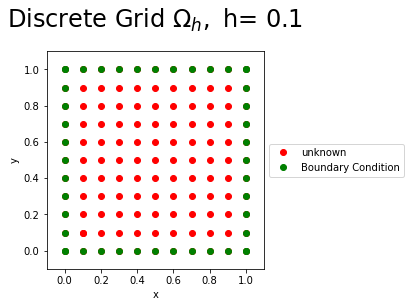

In [2]:
N=10
h=1/N
x=np.arange(0,1.0001,h)
y=np.arange(0,1.0001,h)
X, Y = np.meshgrid(x, y)
fig = plt.figure()
plt.plot(x[1],y[1],'ro',label='unknown');
plt.plot(X,Y,'ro');
plt.plot(np.ones(N+1),y,'go',label='Boundary Condition');
plt.plot(np.zeros(N+1),y,'go');
plt.plot(x,np.zeros(N+1),'go');
plt.plot(x, np.ones(N+1),'go');
plt.xlim((-0.1,1.1))
plt.ylim((-0.1,1.1))
plt.xlabel('x')
plt.ylabel('y')
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title(r'Discrete Grid $\Omega_h,$ h= %s'%(h),fontsize=24,y=1.08)
plt.show();

## Boundary Conditions

The  discrete boundary conditions are 
$$ w_{i0}=w[i,0]=\sin(2\pi x[i]), \text{ for } i=0,...,10, \text{ upper},$$  

$$  w_{iN}=w[i,N]=\sin(2\pi x[i]), \text{ for } i=0,...,10,  \text{ lower},$$

$$  w_{0j}=w[0,j]=2\sin(2\pi y[j]), \text{ for } j=0,...,10,   \text{ left},$$
$$  w_{Nj}=w[N,j]=2\sin(2\pi y[j]), \text{ for } i=0,...,10,\text{ right}. $$

The Figure below plots the boundary values of $w[i,j]$.

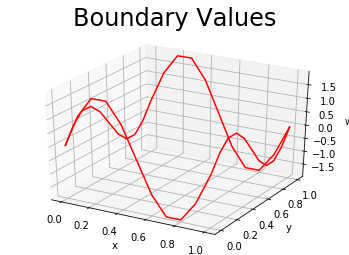

In [3]:
w=np.zeros((N+1,N+1))

for i in range (0,N):
        w[i,0]=np.sin(2*np.pi*x[i]) #left Boundary
        w[i,N]=np.sin(2*np.pi*x[i]) #Right Boundary

for j in range (0,N):
        w[0,j]=2*np.sin(2*np.pi*y[j]) #Lower Boundary
        w[N,j]=2*np.sin(2*np.pi*y[j]) #Upper Boundary

        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
# Plot a basic wireframe.
ax.plot_wireframe(X, Y, w,color='r', rstride=10, cstride=10)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('w')
plt.title(r'Boundary Values',fontsize=24,y=1.08)
plt.show()

## Numerical Method
The Poisson Equation  is discretised using 
$\delta_x^2$ is the central difference approximation of the second derivative in the $x$ direction
$$\delta_x^2=\frac{1}{h^2}(w_{i+1j}-2w_{ij}+w_{i-1j}), $$
and $\delta_y^2$ is the central difference approximation of the second derivative in the $y$ direction
$$\delta_y^2=\frac{1}{h^2}(w_{ij+1}-2w_{ij}+w_{ij-1}). $$
The gives the Poisson Difference Equation,
$$-(\delta_x^2w_{ij}+\delta_y^2w_{ij})=f_{ij} \ \ (x_i,y_j) \in \Omega_h, $$
$$w_{ij}=g_{ij} \ \ (x_i,y_j) \in \partial\Omega_h, $$
where $w_ij$ is the numerical approximation of $U$ at $x_i$ and $y_j$.
Expanding the  the Poisson Difference Equation gives the five point method,
$$-(w_{i-1j}+w_{ij-1}-4w_{ij}+w_{ij+1}+w_{i+1j})=h^2f_{ij} $$
for $i=1,...,N-1$ and $j=1,...,N-1.$

### Matrix form
This can be written as a system of $(N-1)\times(N-1)$ equations can be arranged in matrix form
$$ A\mathbf{w}=\mathbf{r},$$
where $A$ is an $(N-1)^2\times(N-1)^2$  matrix made up of the following block tridiagonal structure
$$\left(\begin{array}{ccccccc}
T&I&0&0&.&.&.\\
I&T&I&0&0&.&.\\
.&.&.&.&.&.&.\\
.&.&.&0&I&T&I\\
.&.&.&.&0&I&T\\
\end{array}\right),
$$
where $I$ denotes an $N-1 \times N-1$ identity matrix and $T$ is the tridiagonal matrix of the form:
$$ T=\left(\begin{array}{ccccccc}
-4&1&0&0&.&.&.\\
1&-4&1&0&0&.&.\\
.&.&.&.&.&.&.\\
.&.&.&0&1&-4&1\\
.&.&.&.&0&1&-4\\
\end{array}\right).
$$
The plot below shows the matrix $A$ and its inverse $A^{-1}$ as a colourplot.

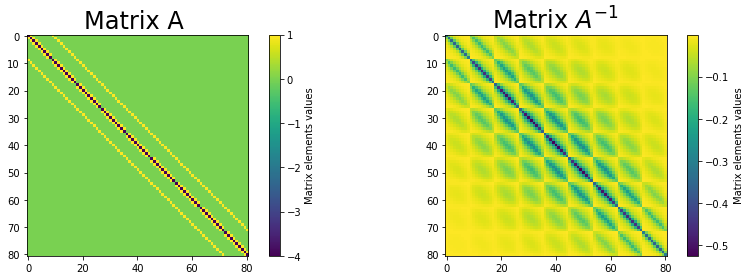

In [4]:
N2=(N-1)*(N-1)
A=np.zeros((N2,N2))
## Diagonal            
for i in range (0,N-1):
    for j in range (0,N-1):           
        A[i+(N-1)*j,i+(N-1)*j]=-4

# LOWER DIAGONAL        
for i in range (1,N-1):
    for j in range (0,N-1):           
        A[i+(N-1)*j,i+(N-1)*j-1]=1   
# UPPPER DIAGONAL        
for i in range (0,N-2):
    for j in range (0,N-1):           
        A[i+(N-1)*j,i+(N-1)*j+1]=1   

# LOWER IDENTITY MATRIX
for i in range (0,N-1):
    for j in range (1,N-1):           
        A[i+(N-1)*j,i+(N-1)*(j-1)]=1        
        
        
# UPPER IDENTITY MATRIX
for i in range (0,N-1):
    for j in range (0,N-2):           
        A[i+(N-1)*j,i+(N-1)*(j+1)]=1
Ainv=np.linalg.inv(A)   
fig = plt.figure(figsize=(12,4));
plt.subplot(121)
plt.imshow(A,interpolation='none');
clb=plt.colorbar();
clb.set_label('Matrix elements values');
plt.title('Matrix A ',fontsize=24)
plt.subplot(122)
plt.imshow(Ainv,interpolation='none');
clb=plt.colorbar();
clb.set_label('Matrix elements values');
plt.title(r'Matrix $A^{-1}$ ',fontsize=24)

fig.tight_layout()
plt.show();



The vector $\mathbf{w}$ is of length $(N-1)\times(N-1)$ which made up of $N-1$ subvectors $\mathbf{w}_j$  of length $N-1$ of the form
$$\mathbf{w}_j=\left(\begin{array}{c}
w_{1j}\\
w_{2j}\\
.\\
.\\
w_{N-2j}\\
w_{N-1j}\\
\end{array}\right).
$$
The vector $\mathbf{r}$ is of length $(N-1)\times(N-1)$ which made up of $N-1$ subvectors of the form $\mathbf{r}_j=-h^2\mathbf{f}_j-\mathbf{bx}_{j}-\mathbf{by}_j$, 
where $\mathbf{bx}_j $ is the vector of left and right boundary conditions 
$$\mathbf{bx}_j =\left(\begin{array}{c}
w_{0j}\\
0\\
.\\
.\\
0\\
w_{Nj}
\end{array}\right),
$$

for $j=1,..,N-1$, where $\mathbf{by}_j$ is the vector of the lower boundary condition for $j=1$,

$$
\mathbf{by}_{1} =\left(\begin{array}{c}
w_{10}\\
w_{20}\\
.\\
.\\
w_{N-20}\\
w_{N-10}\\
\end{array}\right),
$$
upper boundary condition for $j=N-1$

$$
\mathbf{by}_{N-1} =\left(\begin{array}{c}
w_{1N}\\
w_{2N}\\
.\\
.\\
w_{N-2N}\\
w_{N-1N}\\
\end{array}\right),
$$
for $j=2,...,N-2$ $$\mathbf{by}_j=0,$$
and 
$$\mathbf{f}_j =100\left(\begin{array}{c}
x_1^2+y_j^2\\
x_2^2+y_j^2\\
.\\
.\\
x_{N-2}^2+y_j^2\\
x_{N-1}^2+y_j^2
\end{array}\right)
$$
for $j=1,...,N-1$.


In [5]:
r=np.zeros(N2)

# vector r      
for i in range (0,N-1):
    for j in range (0,N-1):           
        r[i+(N-1)*j]=100*h*h*(x[i+1]*x[i+1]+y[j+1]*y[j+1])     
# Boundary        
b_bottom_top=np.zeros(N2)
for i in range (0,N-1):
    b_bottom_top[i]=np.sin(2*np.pi*x[i+1]) #Bottom Boundary
    b_bottom_top[i+(N-1)*(N-2)]=np.sin(2*np.pi*x[i+1])# Top Boundary
      
b_left_right=np.zeros(N2)
for j in range (0,N-1):
    b_left_right[(N-1)*j]=2*np.sin(2*np.pi*y[j+1]) # Left Boundary
    b_left_right[N-2+(N-1)*j]=2*np.sin(2*np.pi*y[j+1])# Right Boundary
    
b=b_left_right+b_bottom_top

## Results

To solve the system for $\mathbf{w}$ invert the matrix $A$
$$ A\mathbf{w}=\mathbf{r},$$
such that
$$ \mathbf{w}=A^{-1}\mathbf{r}.$$
Lastly, as $\mathbf{w}$ is in vector it has to be reshaped into grid form to plot.

The figure below shows the numerical approximation of the homogeneous Equation.

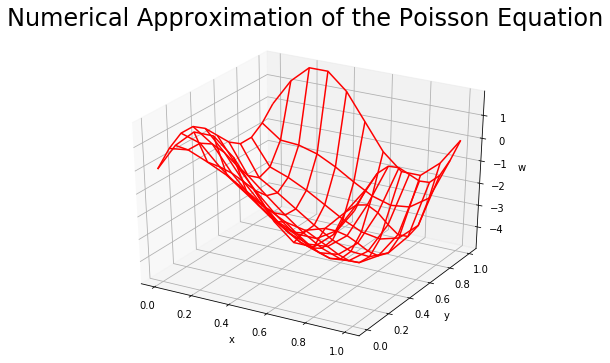

In [6]:
C=np.dot(Ainv,r-b)
w[1:N,1:N]=C.reshape((N-1,N-1))

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d');
# Plot a basic wireframe.
ax.plot_wireframe(X, Y, w,color='r');
ax.set_xlabel('x');
ax.set_ylabel('y');
ax.set_zlabel('w');
plt.title(r'Numerical Approximation of the Poisson Equation',fontsize=24,y=1.08);
plt.show();

# Consistency and Convergence
We now ask how well the grid function determined by the five point scheme approximates the exact solution of the Poisson problem.
## Consistency

### Consitency (Definition)
Let 
$$\nabla^2_h(\varphi)=-(\varphi_{i-1j}+\varphi_{ij-1}-4\varphi_{ij}+\varphi_{ij+1}+\varphi_{i+1j})$$ 
denote the finite difference approximation associated with the grid $\Omega_h$ having the mesh size $h$, to a partial differential operator 
$$\nabla^2(\varphi)=\frac{\partial^2 \varphi}{\partial x^2}+\frac{\partial^2 \varphi}{\partial y^2}$$ defined on
a simply connected, open set $\Omega \subset R^2$. For a given function $\varphi\in C^{\infty}(\Omega)$,
the truncation error of $\nabla^2_h$ is
$$\tau_{h}(\mathbf{x})=(\nabla^2-\nabla^2_h)\varphi(\mathbf{x}) $$
The approximation $\nabla^2_h$ is consistent with $\nabla^2$ if
$$ \lim_{h\rightarrow 0}\tau_h(\mathbf{x})=0,$$
for all $\mathbf{x} \in D$ and all $\varphi \in C^{\infty}(\Omega)$. The approximation is consistent to order $p$ if $\tau_h(\mathbf{x})=O(h^p)$.

_In other words a method is consistent with the differential equation it is approximating._

## Proof of Consistency
The five-point difference analog $\nabla^2_h$ is consistent to order 2 with $\nabla^2$.

__Proof__

Pick $\varphi \in C^{\infty}(D)$, and let $(x,y) \in \Omega$ be a point such that $(x\pm h, y),(x,y \pm h) \in \Omega\bigcup \partial\Omega$.  By the Taylor Theorem
\begin{eqnarray*}
\varphi(x\pm h,y)&=&\varphi(x,y) \pm h \frac{\partial \varphi}{\partial x}(x,y)+\frac{h^2}{2!}\frac{\partial^2 \varphi}{\partial x^2}(x,y) \pm\frac{h^3}{3!}\frac{\partial^3 \varphi}{\partial x^3}(x,y)+\frac{h^4}{4!}\frac{\partial^4 \varphi}{\partial x^4}(\zeta^{\pm},y)
\end{eqnarray*}
where $\zeta^{\pm} \in (x-h,x+h)$. Adding this pair of equation together and rearranging , we get
$$\frac{1}{h^2}[\varphi(x+h,y)-2\varphi(x,y)+\varphi(x-h,y) ] -\frac{\partial^2 \varphi}{\partial x^2}(x,y)=\frac{h^2}{4!}\left[\frac{\partial^4 \varphi}{\partial x^4}(\zeta^{+},y)+
\frac{\partial^4 \varphi}{\partial x^4}(\zeta^{-},y)
 \right]
$$
By the intermediate value theorem
$$\left[\frac{\partial^4 \varphi}{\partial x^4}(\zeta^{+},y)+
\frac{\partial^4 \varphi}{\partial x^4}(\zeta^{-},y)
 \right]
=2\frac{\partial^4 \varphi}{\partial x^4}(\zeta,y),$$
for some $\zeta \in (x-h,x+h)$.  Therefore,
$$\delta_x^2(x,y)
=\frac{\partial^2 \varphi}{\partial x^2}(x,y)+\frac{h^2}{2!}\frac{\partial^4 \varphi}{\partial x^4}(\zeta,y)$$
Similar reasoning shows that
$$\delta_y^2(x,y)
=\frac{\partial^2 \varphi}{\partial y^2}(x,y)+\frac{h^2}{2!}\frac{\partial^4 \varphi}{\partial y^4}(x,\eta)
$$
for some $\eta \in (y-h,y+h)$. We conclude that $\tau_h(x,y)=(\nabla-\nabla_h)\varphi(x,y)=O(h^2).$



## Convergence
### Definition
Let $\nabla^2_hw(\mathbf{x}_j)=f(\mathbf{x}_j)$ be a finite difference approximation, defined on a grid mesh size $h$, to a PDE $\nabla^2U(\mathbf{x})=f(\mathbf{x})$ on a simply connected set $D \subset R^n$. Assume that $w(x,y)=U(x,y)$ at all points $(x,y)$ on the boundary $\partial\Omega$.  The finite difference scheme converges (or is convergent) if
$$ \max_j|U(\mathbf{x}_j)-w(\mathbf{x}_j)| \rightarrow 0 \mbox{  as  } h \rightarrow 0.$$


### Theorem (DISCRETE MAXIMUM PRINCIPLE).
If $\nabla^2_hV_{ij}\geq 0$ for all points $(x_i,y_j) \in \Omega_h$, then
$$ \max_{(x_i,y_j)\in\Omega_h}V_{ij}\leq  \max_{(x_i,y_j)\in\partial\Omega_h}V_{ij},$$
If $\nabla^2_hV_{ij}\leq 0$ for all points $(x_i,y_j) \in \Omega_h$, then
$$ \min_{(x_i,y_j)\in\Omega_h}V_{ij}\geq  \min_{(x_i,y_j)\in\partial\Omega_h}V_{ij}.$$

### Propositions
1. The zero grid function (for which $U_{ij}=0$ for all $(x_i,y_j) \in \Omega_h \bigcup \partial\Omega_h$
is the only solution to the finite difference problem
$$\nabla_h^2U_{ij}=0 \mbox{ for }(x_i,y_j)\in\Omega_h,$$
$$U_{ij}=0 \mbox{ for }(x_i,y_j)\in\partial\Omega_h.$$

2. For prescribed grid functions $f_{ij}$ and $g_{ij}$, there exists a unique solution to the problem
$$\nabla_h^2U_{ij}=f_{ij} \mbox{ for }(x_i,y_j)\in\Omega_h,$$
$$U_{ij}=g_{ij} \mbox{ for }(x_i,y_j)\in\partial\Omega_h.$$


### Definition
For any grid function $V:\Omega_h\bigcup\partial\Omega_h \rightarrow R$,
$$||V||_{\Omega} =\max_{(x_i,y_j)\in\Omega_h}|V_{ij}|, $$
$$||V||_{\partial\Omega} =\max_{(x_i,y_j)\in\partial\Omega_h}|V_{ij}|. $$

### Lemma
If the grid function $V:\Omega_h\bigcup\partial\Omega_h\rightarrow R$ satisfies the boundary condition $V_{ij}=0$ for $(x_i,y_j)\in \partial\Omega_h$, then
$$||V_||_{\Omega}\leq \frac{1}{8}||\nabla_h^2V||_{\Omega}. $$

Given these Lemmas and Propositions, we can now prove that the solution to the five point scheme $\nabla^2_h$ is convergent to the exact solution of the Poisson Equation $\nabla^2$.
### Convergence Theorem
Let $U$ be a solution to the \addtoindex{Poisson equation} and let $w$ be the grid function
that satisfies the discrete analog
$$-\nabla_h^2w_{ij}=f_{ij} \ \ \mbox{ for } (x_i,y_j)\in\Omega_h, $$
$$w_{ij}=g_{ij} \ \ \mbox{ for } (x_i,y_j)\in\partial\Omega_h. $$
Then there exists a positive constant $K$ such that
$$||U-w||_{\Omega}\leq KMh^2, $$
where
$$ M=\left\{
\left|\left|\frac{\partial^4 U}{\partial x^4} \right|\right|_{\infty},
\left|\left|\frac{\partial^4 U}{\partial y^4} \right|\right|_{\infty}
 \right\}$$
 
 __Proof__
 
 The statement of the theorem assumes that $U\in C^4(\bar{\Omega})$. This assumption
holds if $f$ and $g$ are smooth enough.
\begin{proof}
Following from the proof of the Proposition we have
$$ (\nabla_h^2-\nabla^2)U_{ij}=\frac{h^2}{12}\left[ \frac{\partial^4 U}{\partial x^4}(\zeta_i,y_j)+\frac{\partial^4 U}{\partial y^4}(x_i,\eta_j) \right],$$
for some $\zeta \in (x_{i-1},x_{i+1})$ and $\eta_j\in(y_{j-1},y_{j+1})$.  Therefore,
$$ -\nabla_h^2U_{ij}=f_{ij}-\frac{h^2}{12}\left[ \frac{\partial^4 U}{\partial x^4}(\zeta_i,y_j)+\frac{\partial^4 U}{\partial y^4}(x_i,\eta_j) \right].$$
If we subtract from this the identity equation $-\nabla_h^2w_{ij}=f_{ij}$ and note
that $U-w$ vanishes on $\partial\Omega_h$, we find that
$$ \nabla_h^2(U_{ij}-w_{ij})=\frac{h^2}{12}\left[ \frac{\partial^4 U}{\partial x^4}(\zeta_i,y_j)+\frac{\partial^4 U}{\partial y^4}(x_i,\eta_j) \right].$$
It follows that
$$ ||U-w||_{\Omega}\leq\frac{1}{8}||\nabla_h^2(U-w)||_{\Omega}\leq KMh^2.$$